In [1]:
import gensim
from IPython.display import clear_output
import json
import re
from random import random, choice, randint
import time
import pickle
from IPython.core.display import display, HTML
import locale, os, socket
from numpy import int64
locale.setlocale(locale.LC_ALL, 'de_DE.utf-8')
import pygraphviz as pgv
from IPython.display import Image, display, display_png, display_svg, SVG
from jinja2 import Template
import codecs

if not os.path.exists('logs'):
    os.makedirs('logs')

host = socket.gethostname() 
if host == 'lyrik':
    model_file = '/home/ramin/projects/ECO/src/python/modelbuilder/parsed_v3_valid.doc2vec'
    print "U ARE ON LYRIK"
    # ... move data and model into some convinient folder. so that model/parsed_v3_valid is there and
    # NAIL_DATAFIELD_txt/parsed_v3/parsed_v3_valid.txt is there
else:
    # local
    model_file = '../../models/NAIL_DATAFIELD_txt/parsed_v3/parsed_v3_valid.doc2vec'    

if not os.path.isfile(model_file):
    print "MODEL FILE IS NOT THERE. GO AND FIND IT"

In [2]:
# 2 Build sentence list (each sentence needs at least 1 tag)

if host == 'lyrik':
    filename = '/home/marcel/drive/data/eco/NAIL_DATAFIELD_txt/parsed_v3/parsed_v3_valid.txt'
else:
    # local
    filename = '../../data/NAIL_DATAFIELD_txt/parsed_v3/parsed_v3_valid.txt' # parsed_v3_all.txt

if not os.path.isfile(model_file):
    print "TEXTFILE FILE IS NOT THERE"    

sentences = []
from random import shuffle

f = codecs.open(filename, 'r', 'UTF-8')
for uid, line in enumerate(f):
    ls = gensim.models.doc2vec.LabeledSentence(words=line.split(), tags=['SENT_%s' % uid])
    sentences.append(ls)
print len(sentences),'sentences'

4266193 sentences


In [3]:
# 3 TRAINING OR LOADING the doc2vec model and save it
# ALTERNATIVE: LOAD THE MODEL IN THE NEXT CELL

# tutorial https://rare-technologies.com/doc2vec-tutorial/
# proposes shuffling or learning reate adjustment. we gonna do both
# in total 20 epochs
# took ca. 6.30 hours

# FOR SAFETY REASON, BUILD ONLY WHEN FLAG IS SET

train_model = False

if train_model:
    model = gensim.models.Doc2Vec(alpha=0.025, min_alpha=0.025)  # use fixed learning rate
    print('building vocab') 
    model.build_vocab(sentences)

    base_alpha = model.alpha
    base_min_alpha = model.min_alpha

    for mepoch in range(2):
        model.alpha = base_alpha 
        model.min_alpha = base_min_alpha
        for epoch in range(10):
            print('epoch',mepoch * 10 + epoch)
            model.train(sentences)
            model.alpha -= 0.002  # decrease the learning rate
            model.min_alpha = model.alpha  # fix the learning rate, no decay
        shuffle(sentences)

    # saving the model    
    model.save(model_file)
    print 'model trained and saved'
else:
    model = gensim.models.Doc2Vec.load(model_file)
    print 'model loaded.',len(model.docvecs), 'vectors'
    if len(sentences) != len(model.docvecs):
        print 'something is fishy, unequal length: ',len(sentences),'sentences and',len(model.docvecs), 'vectors'

model loaded. 4266193 vectors


In [4]:
# 4 Tiny helper functions

def print_word_list(wl):
    str =  ' '.join(wl)
    pattern = re.compile('\s\W\s')
    shift = 0
    for ma in pattern.finditer(str):
        str = str[:ma.start(0)-shift]+ma.group(0)[1:]+ str[ma.end(0)-shift:]
        shift +=1
    if str[-2] == ' ':
        str = str[:-2] + str[-1:]
    return str

def get_print(sentence_or_similar):
    if type(sentence_or_similar) is gensim.models.doc2vec.LabeledSentence:
        word_list = sentence_or_similar.words
    elif type(sentence_or_similar) is int64 or type(sentence_or_similar) is int: # just an index
        word_list = sentences[sentence_or_similar].words
    else: # TaggedDocument class
        word_list = sentences[int(sentence_or_similar[0][5:])][0]
    return print_word_list(word_list)
    
def get_index_tag(sentence):
    return sentence.tags[0]

def get_index(sentence_or_similar):
    if type(sentence_or_similar) is gensim.models.doc2vec.LabeledSentence:
        return int64(get_index_tag(sentence_or_similar)[5:])
    else:
        return int64(sentence_or_similar[0][5:])
    
def equal_word_lists(index1, index2):
    wl1 = sentences[index1].words
    wl2 = sentences[index2].words
    if len(wl1) != len(wl2):
        return False
    else:
        for i in range(len(wl1)):
            if wl1[i] != wl2[i]:
                return False
    return True

def get_lab_sent_by_similar(similar):
    print get_index(similar)
    return sentences[get_index(similar)]

def get_similarity_by_index(index1, index2):
    return model.docvecs.similarity(index1,index2)

def linebreak(sentence, afterChar):
    wordlist = sentence.split(' ')
    line_length = 0 
    result = ''
    for word in wordlist:
        line_length += len(word)
        result += word+' '
        if line_length > afterChar:
            result += '\n'
            line_length = 0
    return result

In [40]:
%%html
<style>
    .similar{
        color: black;
    }
    .random{
        color: red;
    }
    .parent{
        color: blue
    }
    .next{
        color: green
    }
    .noIndex {
        list-style-type: none;
    }
</style>

In [90]:
class ConversationTree:
    
    def __init__(self, root_sentence):
        self.G = pgv.AGraph(strict=True, directed=True)
        # Basic styling
        self.G.node_attr['shape']='box'
        #
        self.next_node_id = 0
        self.actual_node = None
        self.inserted_sentence_indices = []
        self.root = self.add_node(root_sentence)
        self.actual_node = self.root
         
    def add_node(self, sentence, edge_label = [], goto = True):
        node = ConversationNode(self, sentence, self.actual_node, edge_label)
        self.inserted_sentence_indices.append(node.sentence_index)
        if goto:
            self.change_actual(node)
        return node
    
    def change_actual(self, new):
        if self.actual_node: # None when adding the root
            self.actual_node.unstyle()
        self.actual_node = new
        self.actual_node.style_actual()        
    
    def next_id(self):
        id_ = self.next_node_id 
        self.next_node_id += 1
        return id_        
    
    def display(self, layout= 'dot', fformat = 'png'):
        if fformat not in ['png','svg']:
            print 'format is not real',fformat
            return
        name = 'simple_'+layout+'.'+fformat
#         self.create_sub_graph()
        tree.G.draw(name, prog = layout)
#         self.G.draw(name, prog = layout)
        if fformat == 'svg':
            display(SVG(name))
        else:
            display(Image(name))   

    def up(self, steps = 1):
        for step in range(steps):
            if self.actual_node.parent_edge:
                self.change_actual(self.actual_node.parent)
            
    ### DOV2VEC stuff

    def get_similars(self):
        return self.actual_node.get_similars()
    
    def get_all_options(self):
        return self.actual_node.get_all_options()
    
    def display_options(self):
        all_options = self.actual_node.get_all_options()
        template = Template('''
        <h2>{{sentence}}</h2>
        <ol>
        {% for item in options %}
        <li class={{item.type}} id="ind{{loop.index}}">{{item.hint}} {{item.sentence}} / {{item.similarity}}</li>
        {% endfor %}
        <li class='noIndex'> q: {{end}} - end </li>
        </ol>
        ''')
        sentence = self.actual_node.pretty_print()
        display(HTML(template.render(sentence = sentence, options = all_options, end = u'💣')))
        return all_options

    def select_option(self):
        all_options = self.display_options()
        selection = raw_input("what's next?") 
        try:
            if selection == 'q':
                return False
            selected_index = int(selection)
        except ValueError:
            return True
        if selected_index >= 1 and selected_index <= len(all_options):
            selected_option =  all_options[selected_index - 1]
            print selected_option['index'], self.actual_node.children
            if selected_option['type'] == 'parent':
                self.up()
                return True
            elif selected_option['index'] in self.actual_node.children:
                self.change_actual(self.actual_node.children[selected_option['index']])
                return True
            else:
                selected_sentence = sentences[int(selected_option['index'])]
                edge_label = [selected_option['similarity'], selected_option['type']]
                self.add_node(selected_sentence, edge_label)
                return True
            
            
class ConversationNode():
    
    def __init__(self, conv_tree, sentence, parent, edge_label = []):
        self.conv_tree = conv_tree
        self.graph = conv_tree.G  
        self.id_ = conv_tree.next_id()
        self.sentence = sentence
        self.sentence_index = get_index(self.sentence)
        self.label = self.build_label()
        self.child_edges = {}
        self.children = {}
        self.g_node = self.update_graph()
        self.style({'label': self.label})
        self.options = None
        if parent:
            self.parent = parent
            self.parent_edge = parent.add_child(self, edge_label)
            self.level = parent.level + 1
        else:
            self.parent = None
            self.parent_edge = None
            self.level = 0
    
    def build_label(self):
        return str(self.id_) +', '+ str(self.sentence_index) +   ' | ' + linebreak(self.pretty_print(),30)
    
    def update_graph(self):
        self.graph.add_node(self.id_)
        g_node = self.graph.get_node(self.id_)
#         self.style({'label': self.label})
        return g_node
    
    def add_child(self, node, edge_label = []):
        self.children[node.sentence_index]  = node
        child_edge = ConversationEdge(self, node,edge_label)   
        self.child_edges[child_edge.id_] = child_edge
        return child_edge

    def style(self, style_dict):
        for k,v in style_dict.iteritems():
            self.g_node.attr[k] = v
    
    def style_actual(self):
        self.style({'color': "orange"}) 
        
    def unstyle(self):
        self.style({'color': "black"})
        
    def pretty_print(self):
        return get_print(self.sentence)
        
    # doc2vec stuff
    
    def get_similars(self):
        similars =  model.docvecs.most_similar(get_index_tag(self.sentence),topn = num_similars)
        return [self.optionFormat(simi) for simi in similars]
    
    def get_randoms(self):
        randoms = []
        for index in range(num_random):
            rnd_sen = sentences[randint(0,len(sentences))]
            randoms.append(rnd_sen)     
        return [self.optionFormat(ran) for ran in randoms]
    
    def get_all_options(self):
        if not self.options:
            all_options = []
            self.similars = self.get_similars()
            self.randoms = self.get_randoms()
            all_options.extend(self.similars)
            if self.parent:
                all_options.append(self.optionFormat(self.parent, 'parent'))
            if self.sentence_index < len(sentences) - 2:
                all_options.append(self.optionFormat(sentences[self.sentence_index + 1],'next'))
            all_options.extend(self.randoms)
            self.options = all_options
        for option in self.options:
            if option['type'] == 'parent':
                option['hint'] = u'👴🏼'
            elif option['type'] == 'next':
                option['hint'] = u'➡️'
            else:
                option['hint'] = u''
            if option['type'] != "parent" and option['index'] in self.conv_tree.inserted_sentence_indices:
                option['hint'] += u'☝️'
            if option['index'] in self.children:
                option['hint'] += u'👶'
        return self.options

    def optionFormat(self, something, info = ''):
        d = {'hint' : ''}
        if type(something) is gensim.models.doc2vec.LabeledSentence:
            d['index'] = get_index(something) 
            d['similarity'] = ("%.3f" % get_similarity_by_index(self.sentence_index, d['index'])) 
            d['sentence'] = get_print(something)
            d['type'] = 'random'
            if info == 'next':
                d['type'] = 'next'
        # similars e.g. ('SENT_78', 0.790978193283081)
        elif isinstance(something, tuple):
            d['index'] = get_index(something)
            d['similarity'] = ("%.3f" % something[1])
            d['sentence'] = get_print(sentences[d['index']])
            d['type'] = 'similar'
        elif isinstance(something, ConversationNode):
            d['index'] = something.sentence_index
            d['similarity'] =("%.3f" % get_similarity_by_index(self.sentence_index, something.sentence_index))
            d['sentence'] = get_print(something.sentence)
            d['type'] = 'parent'
        return d
    
    
class ConversationEdge(object):
        
    def __init__(self,from_node, to_node , label = []):
        self.id_ = (from_node.id_, to_node.id_)
        self.from_node = from_node
        self.to_node = to_node
        self.g_edge = self.update_graph()
        self.style({'label':' '+label[0]})
        if label[1] == 'next':
            self.style({'color':'green'})
        elif label[1] == 'random':
            self.style({'color':'red'})
    def update_graph(self):
        self.from_node.graph.add_edge(self.id_)
        g_edge = self.from_node.graph.get_edge(*self.id_)     
        return g_edge

    
    def style(self, style_dict):
        for k,v in style_dict.iteritems():
            self.g_edge.attr[k] = v
            

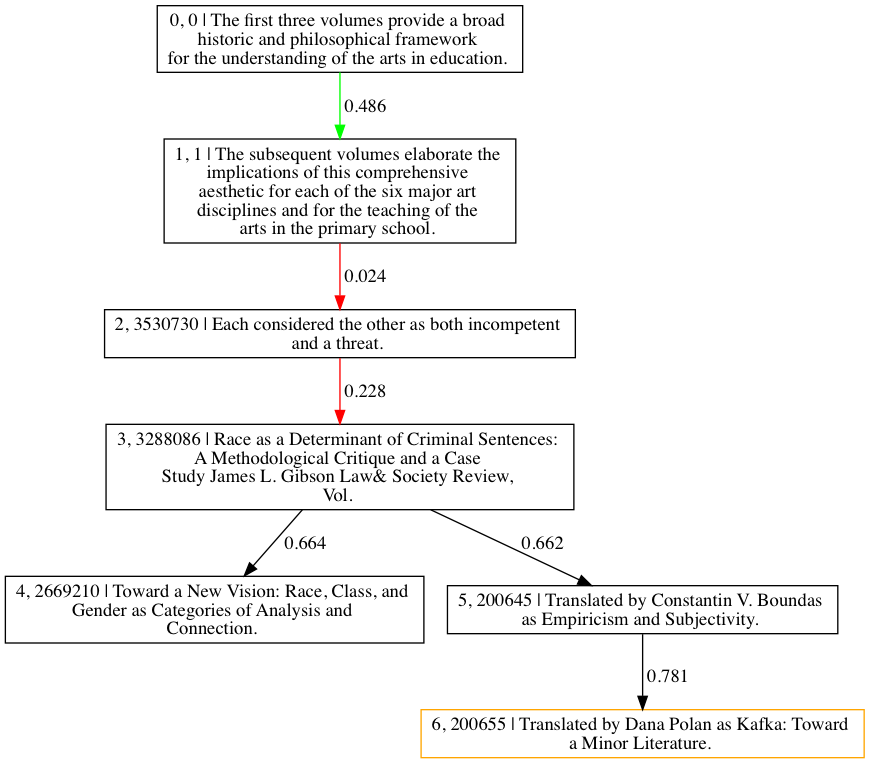

what's next?q


In [91]:
num_similars = 5
num_random = 5

tree = ConversationTree(sentences[0])

while True:
    clear_output()
    tree.display()
    if not tree.select_option():
        break